# Attacking Midfielders & Wingers — PCA & Clustering Analysis

**Goal:** Prepare features and run PCA + GMM clustering for the **Attacking Midfielders & Wingers** cohort (Wing Backs/Full Backs + Holding Midfielders + Central Midfielders).


## 1. Imports & Configuration


In [18]:
import os
import json
from pathlib import Path
import warnings
from dotenv import load_dotenv

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from scipy.stats import mstats
from statsbombpy import sb

warnings.filterwarnings('ignore')

# Load environment variables
load_dotenv()

# Set credentials if available
username = os.getenv('SB_USERNAME')
password = os.getenv('SB_PASSWORD')
creds = {'user': username, 'passwd': password} if username and password else None

if creds:
    print("✓ Credentials loaded successfully")
else:
    print("⚠ No credentials found - using open data access only")

# Configuration
RANDOM_SEED = 42
MIN_MINUTES = 500
MISSING_THRESHOLD = 0.30  # Drop features with ≥30% missing
COVERAGE_360_THRESHOLD = 0.70  # Keep 360 metrics if ≥70% have data
WINSORIZE_LIMITS = (0.01, 0.99)  # 1st and 99th percentiles
COLLINEARITY_THRESHOLD = 0.90  # Drop one feature if |r| ≥ 0.90
NORMALIZATION_MODE = "zscore"  # Options: "zscore" or "l2"
COMPETITION_ID = 73  # Liga MX

np.random.seed(RANDOM_SEED)

# Plotting defaults
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['figure.dpi'] = 100

print("✓ Imports complete")
print(f"Config: MIN_MINUTES={MIN_MINUTES}, NORMALIZATION_MODE={NORMALIZATION_MODE}, COMPETITION_ID={COMPETITION_ID}")


✓ Credentials loaded successfully
✓ Imports complete
Config: MIN_MINUTES=500, NORMALIZATION_MODE=zscore, COMPETITION_ID=73


## 2. Paths & Logger Setup


In [19]:
# Artifact directory
ARTIFACT_BASE = Path("../data/processed/attacking_midfielders_wingers_artifacts")
ARTIFACT_BASE.mkdir(parents=True, exist_ok=True)

def get_season_artifact_dir(season_id: int, season_name: str) -> Path:
    """Create and return season-specific artifact directory."""
    season_dir = ARTIFACT_BASE / str(season_id)
    season_dir.mkdir(parents=True, exist_ok=True)
    return season_dir

def log_message(msg: str, level: str = "INFO"):
    """Simple logger."""
    print(f"[{level}] {msg}")

print(f"✓ Artifact base directory: {ARTIFACT_BASE.absolute()}")


✓ Artifact base directory: c:\Users\carls\OneDrive\Dokumente\Uni\05 Semester\Marketing y Estrategia de Deportes\Projekt\Repo\ISAC2025\notebooks\..\data\processed\attacking_midfielders_wingers_artifacts


## 3. Position Definitions


In [20]:
# Positions in scope
ATTACKING_MID_WINGER_POSITIONS = [
    # Wide Midfielders
    "Right Midfielder",
    "Left Midfielder",
    
    # Wingers
    "Right Wing",
    "Left Wing",
    
    # Attacking Midfielders
    "Right Attacking Midfielder",
    "Centre Attacking Midfielder",
    "Left Attacking Midfielder"
]

print("✓ Attacking Midfielder & Winger positions defined:")
for pos in ATTACKING_MID_WINGER_POSITIONS:
    print(f"  - {pos}")

✓ Attacking Midfielder & Winger positions defined:
  - Right Midfielder
  - Left Midfielder
  - Right Wing
  - Left Wing
  - Right Attacking Midfielder
  - Centre Attacking Midfielder
  - Left Attacking Midfielder


## 4. Feature Definitions


In [21]:
# Combined feature list for Attacking Midfielders & Wingers
BASE_FEATURES = [
    # --- Offensive Production ---
    'player_season_goals_90', 'player_season_npg_90', 'player_season_np_xg_90',
    'player_season_np_xg_per_shot', 'player_season_conversion_ratio',
    'player_season_shot_on_target_ratio', 'player_season_shot_touch_ratio',
    'player_season_touches_inside_box_90', 'player_season_over_under_performance_90',
    'player_season_npxgxa_90',
    
    # --- Chance Creation & Playmaking ---
    'player_season_assists_90', 'player_season_op_assists_90',
    'player_season_key_passes_90', 'player_season_op_key_passes_90',
    'player_season_sp_assists_90', 'player_season_sp_key_passes_90',
    'player_season_through_balls_90', 'player_season_xa_90',
    'player_season_op_xa_90', 'player_season_sp_xa_90',
    'player_season_xgchain_90', 'player_season_xgbuildup_90',
    'player_season_shots_key_passes_90',
    
    # --- Ball Progression & Involvement ---
    'player_season_carries_90', 'player_season_carry_length', 'player_season_carry_ratio',
    'player_season_deep_completions_90', 'player_season_deep_progressions_90',
    'player_season_op_passes_90', 'player_season_passes_into_box_90',
    'player_season_op_passes_into_box_90', 'player_season_lbp_90',
    'player_season_lbp_completed_90', 'player_season_lbp_ratio',
    'player_season_f3_lbp_90', 'player_season_f3_lbp_completed_90',
    'player_season_f3_lbp_ratio', 'player_season_obv_dribble_carry_90',
    'player_season_obv_pass_90', 'player_season_obv_shot_90',
    'player_season_obv_defensive_action_90', 'player_season_positive_outcome_90',
    'player_season_positive_outcome_score',
    
    # --- Width & Crossing ---
    'player_season_crosses_90', 'player_season_crossing_ratio',
    'player_season_box_cross_ratio', 'player_season_average_f3_space_received_in',
    'player_season_f3_ball_receipts_in_space_5_ratio',
    'player_season_f3_ball_receipts_in_space_10_ratio',
    'player_season_f3_lbp_received_90', 'player_season_f3_obv_lbp_90',
    
    # --- Passing Style & Directionality ---
    'player_season_passing_ratio', 'player_season_forward_pass_proportion',
    'player_season_backward_pass_proportion', 'player_season_sideways_pass_proportion',
    'player_season_pass_into_danger_ratio', 'player_season_pass_into_pressure_ratio',
    'player_season_p_pass_length', 'player_season_s_pass_length',
    'player_season_pass_length_ratio', 'player_season_op_f3_forward_pass_proportion',
    'player_season_op_f3_backward_pass_proportion', 'player_season_op_f3_sideways_pass_proportion',
    
    # --- Ball Retention & Risk ---
    'player_season_total_dribbles_90', 'player_season_dribbles_90',
    'player_season_failed_dribbles_90', 'player_season_dribble_ratio',
    'player_season_turnovers_90', 'player_season_dispossessions_90',
    'player_season_errors_90',
    
    # --- Defensive & Pressing Workrate ---
    'player_season_pressures_90', 'player_season_fhalf_pressures_90',
    'player_season_fhalf_pressures_ratio', 'player_season_counterpressures_90',
    'player_season_fhalf_counterpressures_ratio', 'player_season_defensive_action_90',
    'player_season_padj_tackles_and_interceptions_90', 'player_season_ball_recoveries_90',
    'player_season_fhalf_ball_recoveries_90',
]

print(f"✓ Total features defined: {len(BASE_FEATURES)}")

✓ Total features defined: 79


In [22]:
# Define all available Liga MX seasons
SEASON_INFO = [
    {"id": 108, "name": "2021/2022", "year": "21/22"},
    {"id": 235, "name": "2022/2023", "year": "22/23"},
    {"id": 281, "name": "2023/2024", "year": "23/24"},
    {"id": 317, "name": "2024/2025", "year": "24/25"}
]

log_message(f"Found {len(SEASON_INFO)} seasons")
for s in SEASON_INFO:
    print(f"  - {s['id']}: {s['name']} ({s['year']})")


[INFO] Found 4 seasons
  - 108: 2021/2022 (21/22)
  - 235: 2022/2023 (22/23)
  - 281: 2023/2024 (23/24)
  - 317: 2024/2025 (24/25)


In [23]:
# Fetch data from all seasons
log_message("\n" + "="*80)
log_message("FETCHING DATA")
log_message("="*80)

all_season_stats = []

for season in SEASON_INFO:
    season_id = season['id']
    season_name = season['name']
    
    log_message(f"Fetching season {season_name} (ID: {season_id})...")
    season_stats = sb.player_season_stats(competition_id=COMPETITION_ID, season_id=season_id, creds=creds)
    
    # Add season information
    season_stats['season_id'] = season_id
    season_stats['season_name'] = season_name
    
    # Create unique player identifier combining player_id and season_id
    season_stats['player_season_id'] = season_stats['player_id'].astype(str) + '_' + season_stats['season_id'].astype(str)
    
    all_season_stats.append(season_stats)
    log_message(f"  - Found {len(season_stats)} player records")

# Combine all seasons
combined_season_stats = pd.concat(all_season_stats, ignore_index=True)
log_message(f"\n✓ Total combined records: {len(combined_season_stats)}")
log_message(f"✓ Columns: {len(combined_season_stats.columns)}")


[INFO] 
[INFO] FETCHING DATA
[INFO] ================================================================================
[INFO] Fetching season 2021/2022 (ID: 108)...
[INFO]   - Found 603 player records
[INFO] Fetching season 2022/2023 (ID: 235)...
[INFO]   - Found 591 player records
[INFO] Fetching season 2023/2024 (ID: 281)...
[INFO]   - Found 623 player records
[INFO] Fetching season 2024/2025 (ID: 317)...
[INFO]   - Found 636 player records
[INFO] 
✓ Total combined records: 2453
[INFO] ✓ Columns: 225


In [24]:
# Filter by positions
log_message("\n" + "="*80)
log_message("POSITION FILTERING")
log_message("="*80)

# Create position filter
position_filter = (
    combined_season_stats['primary_position'].isin(ATTACKING_MID_WINGER_POSITIONS) | 
    combined_season_stats['secondary_position'].isin(ATTACKING_MID_WINGER_POSITIONS)
)

attacking_mid_winger_stats = combined_season_stats[position_filter].copy()
log_message(f"Players matching positions: {len(attacking_mid_winger_stats)}")

# Filter by minutes
combined_filtered = attacking_mid_winger_stats[attacking_mid_winger_stats['player_season_minutes'] >= MIN_MINUTES].copy()
log_message(f"Players with {MIN_MINUTES}+ minutes: {len(combined_filtered)}")

# Show position distribution
log_message(f"\n✓ Position distribution (primary):")
primary_positions = combined_filtered['primary_position'].value_counts()
for pos, count in primary_positions.items():
    print(f"  - {pos}: {count}")

log_message(f"\n✓ Players per season:")
season_counts = combined_filtered['season_name'].value_counts().sort_index()
for season, count in season_counts.items():
    print(f"  - {season}: {count}")

log_message(f"\n✓ Total player-seasons for analysis: {len(combined_filtered)}")


[INFO] 
[INFO] POSITION FILTERING
[INFO] ================================================================================
[INFO] Players matching positions: 750
[INFO] Players with 500+ minutes: 474
[INFO] 
✓ Position distribution (primary):
  - Right Wing: 80
  - Centre Attacking Midfielder: 79
  - Left Wing: 79
  - Left Midfielder: 57
  - Right Midfielder: 52
  - Centre Forward: 15
  - Left Back: 15
  - Right Back: 14
  - Left Wing Back: 14
  - Left Centre Midfielder: 12
  - Left Defensive Midfielder: 9
  - Left Centre Forward: 8
  - Right Centre Midfielder: 6
  - Right Centre Back: 6
  - Right Centre Forward: 6
  - Goalkeeper: 5
  - Right Defensive Midfielder: 5
  - Left Centre Back: 4
  - Right Wing Back: 4
  - Left Attacking Midfielder: 3
  - Right Attacking Midfielder: 1
[INFO] 
✓ Players per season:
  - 2021/2022: 120
  - 2022/2023: 116
  - 2023/2024: 125
  - 2024/2025: 113
[INFO] 
✓ Total player-seasons for analysis: 474


## 5. Feature Extraction & Preprocessing


In [25]:
# Extract features from combined dataset
log_message("\n" + "="*80)
log_message("FEATURE EXTRACTION & PREPROCESSING")
log_message("="*80)

# Check which features are available in the combined dataset
available_features = [f for f in BASE_FEATURES if f in combined_filtered.columns]
missing_features = [f for f in BASE_FEATURES if f not in combined_filtered.columns]

log_message(f"Available features: {len(available_features)}")
log_message(f"Missing features: {len(missing_features)}")
if missing_features:
    log_message("Missing features:", "WARNING")
    for feat in missing_features[:10]:  # Show first 10
        print(f"  - {feat}")

attacking_mid_winger_features = combined_filtered[available_features].copy()

# 1. Drop high-NaN columns
nan_threshold = 0.4
valid_cols = attacking_mid_winger_features.columns[attacking_mid_winger_features.isna().mean() <= nan_threshold]
attacking_mid_winger_features = attacking_mid_winger_features[valid_cols]
log_message(f"\n1. Features after NaN filtering (>{nan_threshold:.0%} threshold): {len(valid_cols)}")

# 2. Impute remaining NaN with median
attacking_mid_winger_features = attacking_mid_winger_features.apply(lambda s: s.fillna(s.median()), axis=0)
log_message(f"2. Remaining NaN values after imputation: {attacking_mid_winger_features.isna().sum().sum()}")

# 3. Drop zero-variance columns
zero_var = attacking_mid_winger_features.std() == 0
attacking_mid_winger_features = attacking_mid_winger_features.loc[:, ~zero_var]
log_message(f"3. Features after zero-variance filtering: {attacking_mid_winger_features.shape[1]}")

# 4. Winsorization (clip to 1st and 99th percentiles)
from scipy.stats import mstats
winsorize_limits = (0.01, 0.99)
attacking_mid_winger_features_winsorized = attacking_mid_winger_features.copy()

for col in attacking_mid_winger_features_winsorized.columns:
    lower = attacking_mid_winger_features_winsorized[col].quantile(winsorize_limits[0])
    upper = attacking_mid_winger_features_winsorized[col].quantile(winsorize_limits[1])
    attacking_mid_winger_features_winsorized[col] = attacking_mid_winger_features_winsorized[col].clip(lower=lower, upper=upper)

log_message(f"4. Winsorized features to [{winsorize_limits[0]:.1%}, {winsorize_limits[1]:.1%}] percentiles")

# 5. Z-score normalization (standardization)
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
attacking_mid_winger_features_scaled = scaler.fit_transform(attacking_mid_winger_features_winsorized)

# Convert back to DataFrame
attacking_mid_winger_features_scaled_df = pd.DataFrame(
    attacking_mid_winger_features_scaled, 
    columns=attacking_mid_winger_features_winsorized.columns, 
    index=combined_filtered['player_season_id']
)
log_message(f"5. Z-score normalized {attacking_mid_winger_features_scaled_df.shape[1]} features")

# 6. Collinearity pruning (drop one feature from pairs with |r| >= 0.90)
collinearity_threshold = 0.90
corr_matrix = attacking_mid_winger_features_scaled_df.corr().abs()

# Upper triangle (avoid double-counting)
upper_tri = corr_matrix.where(
    np.triu(np.ones(corr_matrix.shape), k=1).astype(bool)
)

# Find features to drop
to_drop = set()
dropped_collinear = {}

for column in upper_tri.columns:
    if column in to_drop:
        continue
    
    high_corr = upper_tri[column][upper_tri[column] >= collinearity_threshold]
    
    for other_feat in high_corr.index:
        if other_feat not in to_drop:
            to_drop.add(other_feat)
            dropped_collinear[other_feat] = f"Correlated with {column} (r={upper_tri.loc[other_feat, column]:.3f})"

if to_drop:
    log_message(f"6. Dropping {len(to_drop)} collinear features (|r| ≥ {collinearity_threshold}):")
    for feat, reason in dropped_collinear.items():
        print(f"  - {feat}: {reason}")
    
    keep_features = [f for f in attacking_mid_winger_features_scaled_df.columns if f not in to_drop]
    attacking_mid_winger_features_scaled_df = attacking_mid_winger_features_scaled_df[keep_features]
else:
    log_message(f"6. No collinear features found (threshold={collinearity_threshold})")

log_message(f"\n✓ Ready for PCA with {attacking_mid_winger_features_scaled_df.shape[1]} features and {attacking_mid_winger_features_scaled_df.shape[0]} players")
log_message(f"✓ Dataset spans {combined_filtered['season_name'].nunique()} seasons: {sorted(combined_filtered['season_name'].unique())}")


[INFO] 
[INFO] FEATURE EXTRACTION & PREPROCESSING
[INFO] ================================================================================
[INFO] Available features: 78
[INFO] Missing features: 1
[WARNING] Missing features:
  - player_season_defensive_action_90
[INFO] 
1. Features after NaN filtering (>40% threshold): 78
[INFO] 2. Remaining NaN values after imputation: 0
[INFO] 3. Features after zero-variance filtering: 78
[INFO] 4. Winsorized features to [1.0%, 99.0%] percentiles
[INFO] 5. Z-score normalized 78 features
[INFO] 6. Dropping 7 collinear features (|r| ≥ 0.9):
  - player_season_goals_90: Correlated with player_season_npg_90 (r=0.955)
  - player_season_assists_90: Correlated with player_season_op_assists_90 (r=0.903)
  - player_season_xa_90: Correlated with player_season_op_xa_90 (r=0.911)
  - player_season_sp_key_passes_90: Correlated with player_season_sp_xa_90 (r=0.938)
  - player_season_lbp_90: Correlated with player_season_lbp_completed_90 (r=0.929)
  - player_season_av

## 6. PCA Fitting & Variance Analysis


In [26]:
# Fit PCA on the standardized features
log_message("\n" + "="*80)
log_message("PCA FITTING")
log_message("="*80)

from sklearn.decomposition import PCA

pca = PCA()
X_pca = pca.fit_transform(attacking_mid_winger_features_scaled_df)

# Explained variance per component
explained_var = pca.explained_variance_ratio_
cum_var = np.cumsum(explained_var)

# Find PCs for variance thresholds
pc_80 = np.where(cum_var >= 0.80)[0][0] + 1 if len(np.where(cum_var >= 0.80)[0]) > 0 else None
pc_90 = np.where(cum_var >= 0.90)[0][0] + 1 if len(np.where(cum_var >= 0.90)[0]) > 0 else None
pc_95 = np.where(cum_var >= 0.95)[0][0] + 1 if len(np.where(cum_var >= 0.95)[0]) > 0 else None

log_message(f"\n✓ PCA Results:")
log_message(f"  - Total components: {len(explained_var)}")
log_message(f"  - PCs for 80% variance: {pc_80}")
log_message(f"  - PCs for 90% variance: {pc_90}")
log_message(f"  - PCs for 95% variance: {pc_95}")

# Print the first 15 components' cumulative variance
print("\nCumulative variance by component:")
for i, var in enumerate(cum_var[:15], 1):
    print(f"PC{i}: {var:.3f}")


[INFO] 
[INFO] PCA FITTING
[INFO] ================================================================================
[INFO] 
✓ PCA Results:
[INFO]   - Total components: 71
[INFO]   - PCs for 80% variance: 17
[INFO]   - PCs for 90% variance: 27
[INFO]   - PCs for 95% variance: 36

Cumulative variance by component:
PC1: 0.203
PC2: 0.364
PC3: 0.438
PC4: 0.496
PC5: 0.547
PC6: 0.587
PC7: 0.622
PC8: 0.652
PC9: 0.676
PC10: 0.697
PC11: 0.716
PC12: 0.735
PC13: 0.752
PC14: 0.768
PC15: 0.783


## 7. PCA Loadings Analysis


In [28]:
# Loadings matrix: features x components
loadings = pd.DataFrame(
    pca.components_.T,
    columns=[f"PC{i+1}" for i in range(pca.n_components_)],
    index=attacking_mid_winger_features_scaled_df.columns
)

# View top contributing features for each of the first 7 PCs
for i in range(7):
    print(f"\nTop 10 features for PC{i+1}:")
    print(loadings.iloc[:, i].abs().sort_values(ascending=False).head(10))



Top 10 features for PC1:
player_season_shots_key_passes_90      0.210953
player_season_key_passes_90            0.208562
player_season_xgchain_90               0.206628
player_season_op_key_passes_90         0.206223
player_season_positive_outcome_90      0.205555
player_season_npxgxa_90                0.201816
player_season_op_passes_into_box_90    0.189794
player_season_f3_lbp_completed_90      0.189126
player_season_op_xa_90                 0.189096
player_season_passes_into_box_90       0.186483
Name: PC1, dtype: float64

Top 10 features for PC2:
player_season_lbp_completed_90                 0.240067
player_season_carry_ratio                      0.234425
player_season_op_passes_90                     0.221835
player_season_backward_pass_proportion         0.202628
player_season_s_pass_length                    0.194512
player_season_obv_pass_90                      0.192518
player_season_shot_touch_ratio                 0.191362
player_season_deep_progressions_90             0.1

## 8. Scree Plot

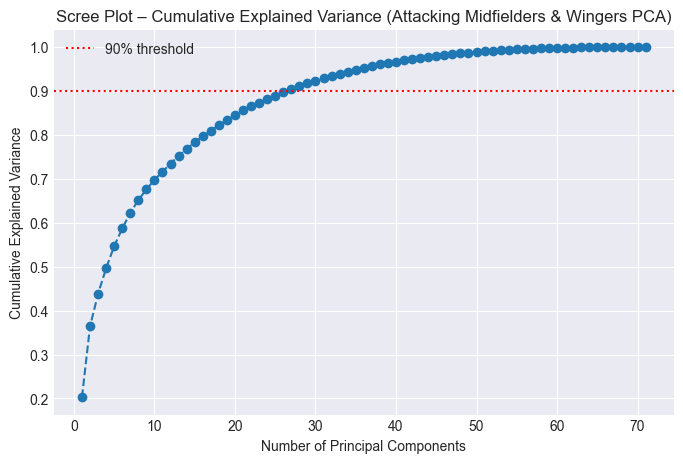

In [27]:
# === Scree plot ===
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(explained_var) + 1), cum_var, marker='o', linestyle='--', color='tab:blue')
plt.title("Scree Plot – Cumulative Explained Variance (Attacking Midfielders & Wingers PCA)")
plt.xlabel("Number of Principal Components")
plt.ylabel("Cumulative Explained Variance")
plt.axhline(0.90, color='red', linestyle=':', label='90% threshold')
plt.grid(True)
plt.legend()
plt.show()
